# Substituting the optimal solution of our algorithm to Jing et al. (2022)

In this notebook, we will investigate what happens when we initialize the algorithm of Jing et al. (2022) by the solution calculated by our algorithm.

In [1]:
# Importing the required libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.animation as animation
import matlab.engine
import io

# The Scaling Case
Here, we will see what happens when we consider the case where we know the exact solution i.e. the scaling case. In [this experiment]([WORKS]ours_vs_jing_scaling.ipynb), it has been observed that their algorithm performs poorly.

In [2]:
# Parameters
Nx = 100 # The size of the spatial grid
Nt = 15 # The size of the temporal grid

# Parameters for our algorithm
delta = 1.0
# We use the default alpha and gamma for the DR algortihm

# Parameters for Jing et al. (2022)
alpha = 1.0  # Originally 5
mu = 0.0007 # Originally 0.007
tao = 0.0007 # Originally 0.007
N_itr = 10000  # Originally 1000000
X = [0, 1] # Originally [-7, 7]
T = [0, 1]

dx = (X[1] - X[0]) / Nx
dt = 1 / Nt

x_space = np.linspace(X[0], X[1], Nx)
x_space_centered = np.linspace(X[0] + dx/2, X[1] - dx/2, Nx-1)
t_space = np.linspace(T[0], T[1], Nt)
t_space_centered = np.linspace(T[0] + dt/2, T[1] - dt/2, Nt)

# The initial density
# Compute densities
rho_0_c = (1/3) * sp.stats.norm.pdf(x_space_centered, loc=0.25, scale=1/10) + (2/3) * sp.stats.norm.pdf(x_space_centered, loc=0.75, scale=1/10)
# Scale so that the integral is 1
rho_0_c = rho_0_c / np.sum(rho_0_c * dx)
scaling_param = 0.5
rho_1_c = scaling_param * rho_0_c

# Calculate the geodesic using our algorithm
ll = (1.0, X[1]-X[0]) # size of time x space box
x_ours, lists = computeGeodesic(rho_0_c, rho_1_c, Nt, ll, p= 2.0, q=2.0, delta=delta, niter=N_itr)

# Jing et al. (2022)
rho_0 = (1/3) * sp.stats.norm.pdf(x_space, loc=0.25, scale=1/10) + (2/3) * sp.stats.norm.pdf(x_space, loc=0.75, scale=1/10)
# Scale so that the integral is 1
rho_0 = rho_0 / np.sum(rho_0 * dx)
scaling_param = 0.5
rho_1 = scaling_param * rho_0

output_buffer = io.StringIO()

print('✨ Starting MATLAB Engine... 🛠️')
eng = matlab.engine.start_matlab()

print('📜 Running WFR_main.m...')
eng.cd(r'..\..\..')
eng.cd(r'.\proximal\code_from_jing_et_al_2022', nargout=0)
eng.workspace['Nx'] = float(Nx)
eng.workspace['Nt'] = float(Nt)
eng.workspace['alpha'] = float(alpha)
eng.workspace['mu'] = mu
eng.workspace['tao'] = tao
eng.workspace['N_itr'] = N_itr
eng.workspace['X'] = X
eng.workspace['T'] = T
eng.workspace['dx'] = dx
eng.workspace['dt'] = dt
eng.workspace['x_space'] = matlab.double(x_space.tolist())
eng.workspace['t_space'] = matlab.double(t_space.tolist())
eng.workspace['rho_0'] = matlab.double(rho_0.tolist())
eng.workspace['rho_1'] = matlab.double(rho_1.tolist())

# Interpoalte the densities to the grid
rho = np.zeros((Nt + 1, Nx))
for i in range(Nt + 1):
    rho[i, :] = np.interp(x_space, x_space_centered, x_ours.U.D[0][i])

eng.workspace['rho'] = matlab.double(rho.tolist())

# Interpolate the momentums to the grid in time
m = np.zeros((Nt, Nx))
for i in range(Nx):
    m[:, i] = np.interp(t_space, t_space_centered, x_ours.U.D[1][:, i])
eng.workspace['m'] = matlab.double(m.tolist())

# Interpolate the source term
intermediate = np.zeros((Nt, Nx-1))
ksi = np.zeros((Nt, Nx))
for i in range(Nx-1):
    intermediate[:, i] = np.interp(t_space, t_space_centered, x_ours.U.Z[:, i])
for i in range(Nt):
    ksi[i, :] = np.interp(x_space, x_space_centered, intermediate[i, :])
eng.workspace['ksi'] = matlab.double(ksi.tolist())

eng.WFR_main(nargout=0, stdout=output_buffer)

print("📤 Retrieving results from MATLAB... 🧩")
rho_opt = eng.workspace['rho_opt'] 
D = eng.workspace['D']  # The squared SWFR distance
Flist = np.array(eng.workspace['Flist'])  # The list of energy values at each iteration
Clist = np.array(eng.workspace['Clist'])  # The list of constraint values at each iteration
C_first = eng.workspace['C_first']  # The first constraint value

# Step 5: Convert rho_opt to a NumPy array
rho_opt_np = np.array(rho_opt)

# Step 6: Stop the MATLAB Engine
eng.quit()
print("✨ MATLAB Engine stopped. 🌟")

✨ Starting MATLAB Engine... 🛠️
📜 Running WFR_main.m...
📤 Retrieving results from MATLAB... 🧩
✨ MATLAB Engine stopped. 🌟


# Results

## WFR distance

In [3]:
print(f'The WFR distance (ours):{np.sqrt(x_ours.V.energy(delta=1.0, p=2.0, q=2.0))}')
print(f'The WFR distance (Jing et al. 2022):{np.sqrt(D*dx*dt)}')
print(f'The WFR distance (exact): {delta*np.abs(np.sqrt(scaling_param)-1)*np.sqrt(2)}')
# The errors between the exact solutions and the two algorithms
print(f'The error between the exact solution and ours: {np.abs(np.sqrt(x_ours.V.energy(delta=1.0, p=2.0, q=2.0)) - delta*np.abs(np.sqrt(0.5)-1)*np.sqrt(2))}')
print(f'The error between the exact solution and Jing et al. 2022: {np.abs(np.sqrt(D*dx*dt) - delta*np.abs(np.sqrt(0.5)-1)*np.sqrt(2))}')

The WFR distance (ours):0.4162722416444408
The WFR distance (Jing et al. 2022):0.42540411240885756
The WFR distance (exact): 0.41421356237309503
The error between the exact solution and ours: 0.002058679271345787
The error between the exact solution and Jing et al. 2022: 0.011190550035762525


## 3D plot

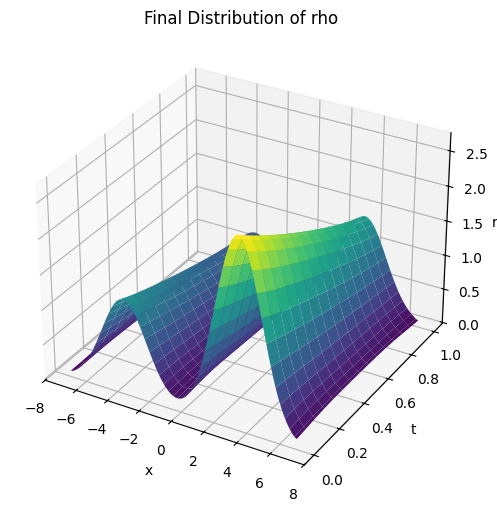

In [4]:
# 3D plot
Nx = rho_opt_np.shape[1]  # Number of spatial points
Nt = rho_opt_np.shape[0]  # Number of time steps
x = np.linspace(-7, 7, Nx)  # Replace with spatial domain bounds
t = np.linspace(0, 1, Nt)  # Replace with time domain bounds
X, T = np.meshgrid(x, t)

# Step 8: Plot rho_opt as a 3D surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, T, rho_opt_np, cmap='viridis')

# Customize plot
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('rho')
ax.set_title('Final Distribution of rho')

# Show plot
plt.show()

## 1D plot

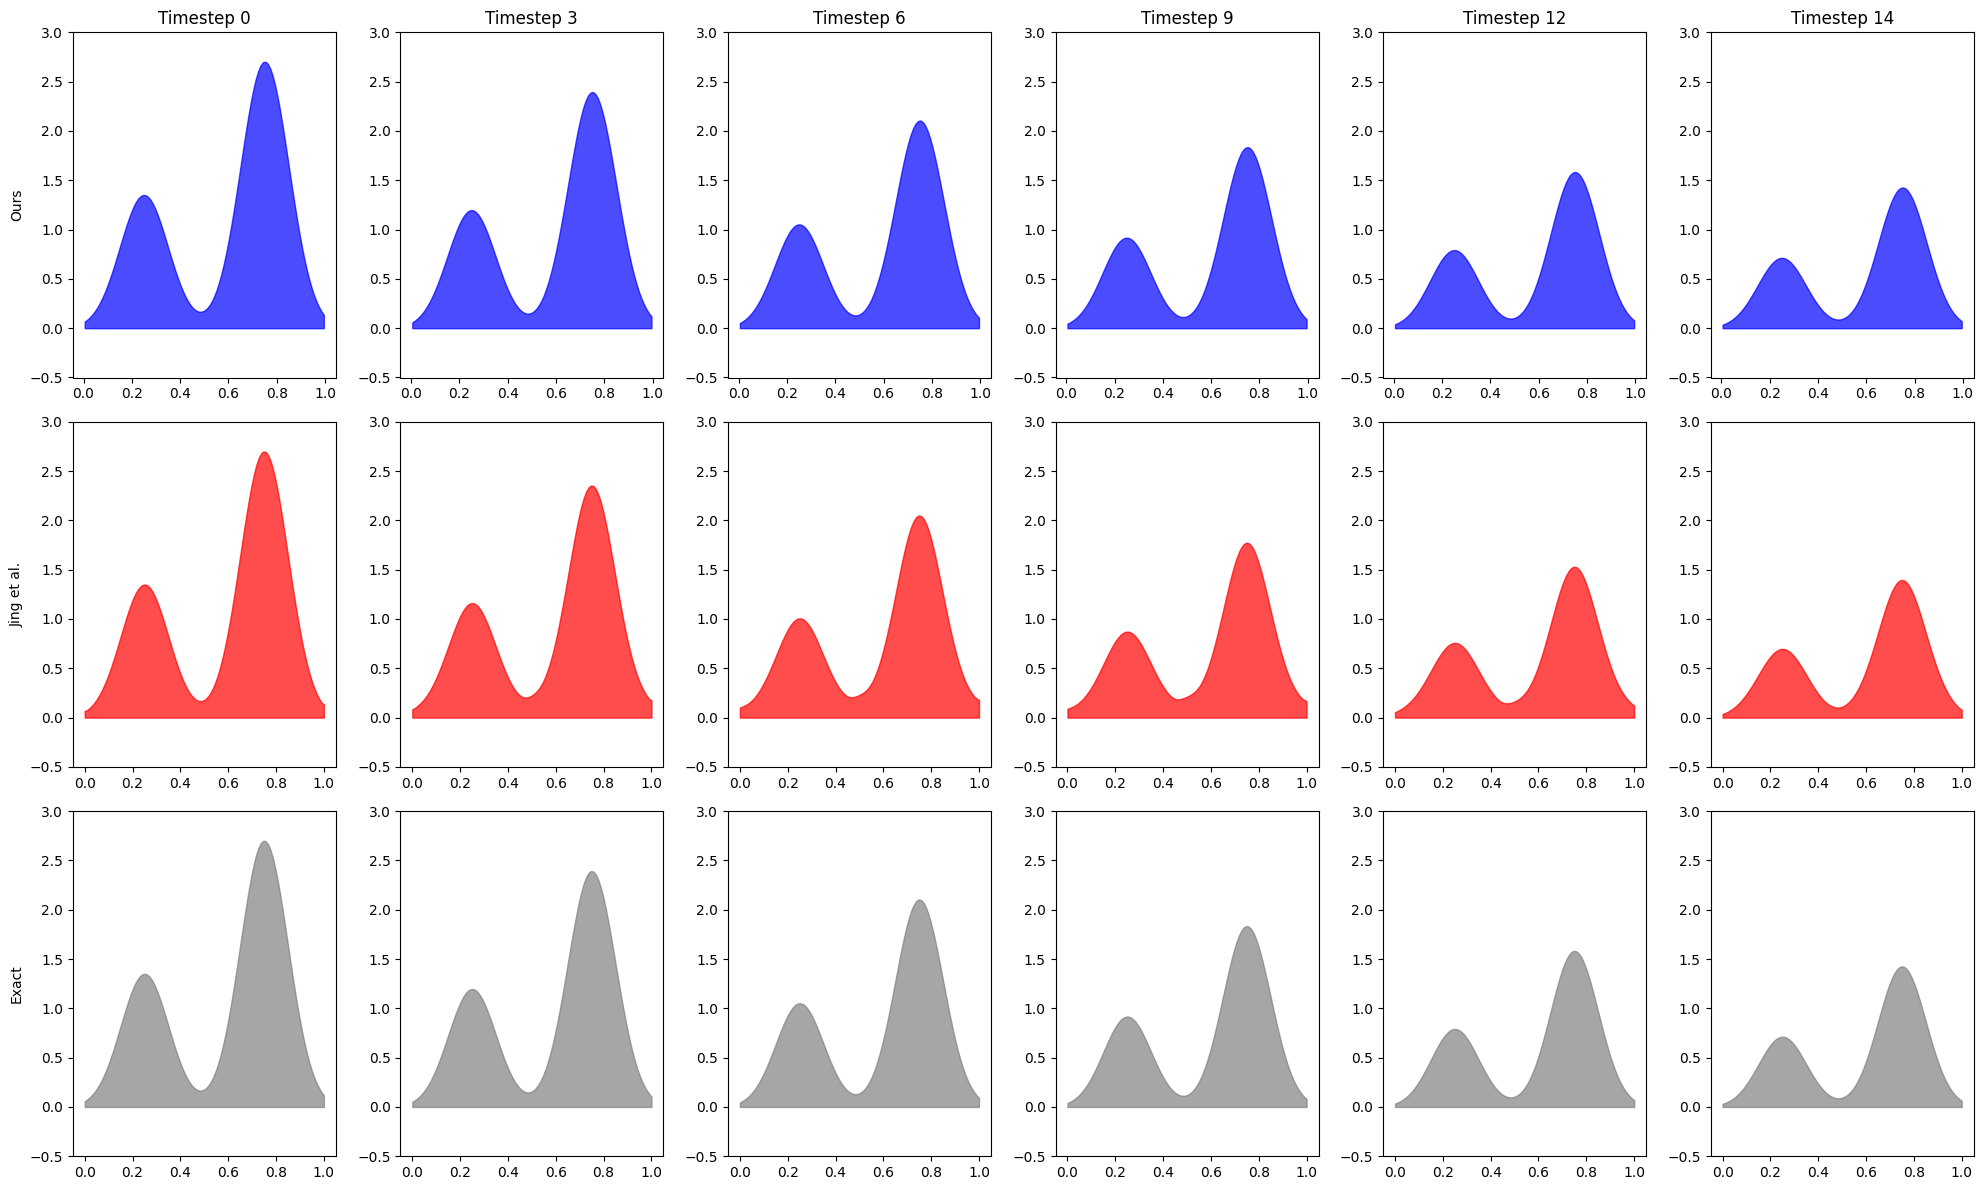

In [5]:
def plot_1D3(t, x, x_ours, X, ylim=[-2, 2], title="" , mplier=1.0):
    plt.figure(figsize=[16, 4])

    plt.fill_between(X, x_ours.U.D[0][t, :], color="b", alpha=0.2, label=r'$\rho_{t}$')
    plt.fill_between(X, x[t, :], color="r", alpha=0.7, label=r'$\rho_{t}$')
    plt.fill_between(X, ((t/Nt)*np.sqrt(scaling_param)+(1-(t/Nt)))**2 * rho_0, color="r", alpha=0.2, label=r'$\rho_0$')
    plt.title(title)
    plt.axis([0, 1, ylim[0], ylim[1]])

#plot_elements4 = [rho_opt_np.copy(), x_ours, x_space.copy(), [-0.5,3], r"Red -  Jing et al.,  Blue - Ours, Gray - Exact", 0.1]
#interact(lambda t: plot_1D3(t, *plot_elements4), t=widgets.IntSlider(min=0, max=Nt-1, step=1, value=0))
# Static plot for selected timesteps
timesteps = [0, 3, 6, 9, 12, 14]
fig, axes = plt.subplots(3, len(timesteps), figsize=(20, 12))

for i, t in enumerate(timesteps):
    # Plot for our algorithm
    axes[0, i].fill_between(x_space_centered, x_ours.U.D[0][t, :], color="b", alpha=0.7)
    axes[0, i].set_title(f'Timestep {t}')
    axes[0, i].set_ylim([-0.5, 3])
    if i == 0:
        axes[0, i].set_ylabel('Ours')

    # Plot for Jing et al. (2022)
    axes[1, i].fill_between(x_space, rho_opt_np[t, :], color="r", alpha=0.7)
    axes[1, i].set_ylim([-0.5, 3])
    if i == 0:
        axes[1, i].set_ylabel('Jing et al.')

    # Plot for exact solution
    exact_rho = ((t/Nt)*np.sqrt(scaling_param)+(1-(t/Nt)))**2 * rho_0
    axes[2, i].fill_between(x_space, exact_rho, color="gray", alpha=0.7)
    axes[2, i].set_ylim([-0.5, 3])
    if i == 0:
        axes[2, i].set_ylabel('Exact')

plt.tight_layout()
plt.show()

## $L^2$ error between the exact solution

In [6]:
# Calculate the exact solution
exact_solution = np.array([((t/Nt)*np.sqrt(scaling_param)+(1-(t/Nt)))**2 * rho_0 for t in range(Nt)])
exact_solution_c = np.array([((t/Nt)*np.sqrt(scaling_param)+(1-(t/Nt)))**2 * rho_0_c for t in range(Nt)])

# Calculate the L2 error
l2_error = np.sqrt(np.sum((rho_opt_np - exact_solution)**2) * dx * dt)

# Print the L2 error
print(f'The L2 error between the exact solution and the computed solution: {l2_error}')
# Calculate the L2 error for our algorithm
l2_error_ours = np.sqrt(np.sum((x_ours.U.D[0][:-1] - exact_solution_c)**2) * dx * dt)

# Print the L2 error for our algorithm
print(f'The L2 error between the exact solution and our algorithm: {l2_error_ours}')

The L2 error between the exact solution and the computed solution: 0.03477617753657097
The L2 error between the exact solution and our algorithm: 7.973252365148138e-05


## Energy value at each iteration

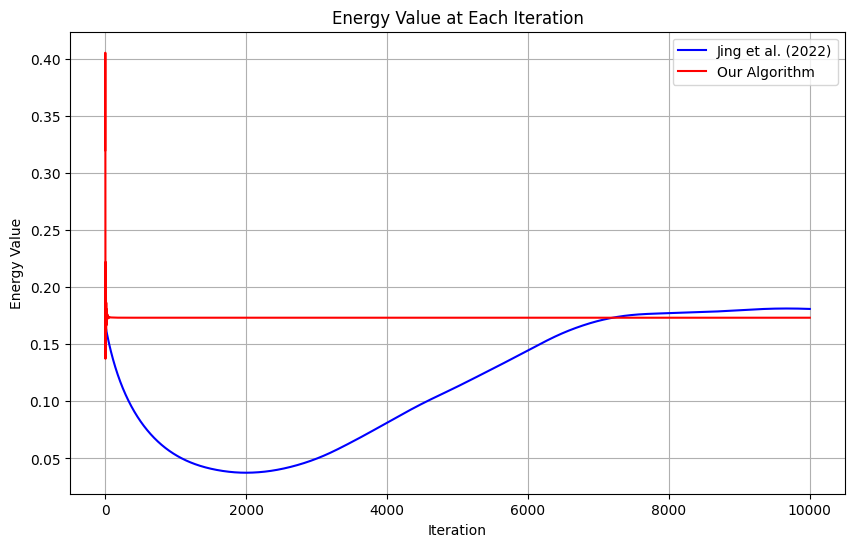

In [7]:
# Plotting the energy values at each iteration for both algorithms
plt.figure(figsize=(10, 6))
plt.plot(Flist, label='Jing et al. (2022)', color='blue')
plt.plot(lists[0], label='Our Algorithm', color='red')
plt.xlabel('Iteration')
plt.ylabel('Energy Value')
plt.title('Energy Value at Each Iteration')
plt.legend()
plt.grid()
plt.show()

# Violation of the continuity equation


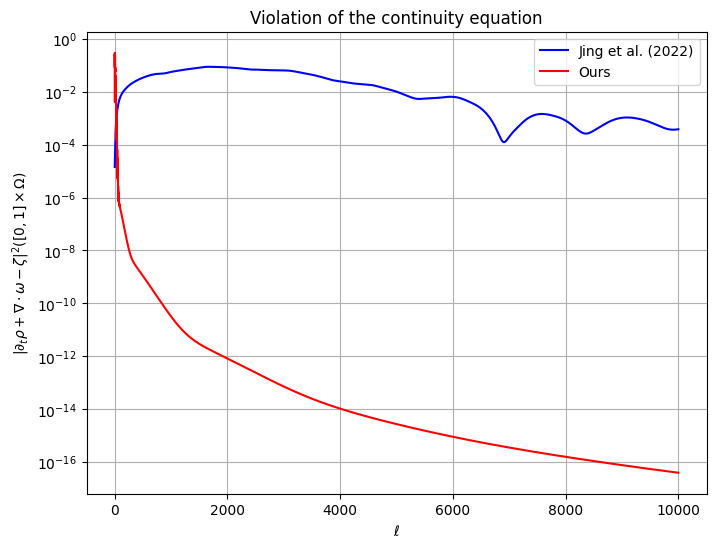

In [8]:
plt.figure(figsize=(8, 6))
plt.ylabel(r"$|\partial_t \rho + \nabla \cdot \omega - \zeta|^2([0,1]\times \Omega)$")
plt.xlabel(r"$\ell$")
plt.title("Violation of the continuity equation")
plt.semilogy(Clist, "b", label="Jing et al. (2022)")
plt.semilogy(lists[1], "r", label="Ours")
plt.legend()
plt.grid()
plt.show()

In [11]:
# Printing the violation of the continuity equation for the inital condition
print(C_first)

1.3041331999829798e-05


We observe that although the solution is better than the [original scaling experiment]([WORKS]ours_vs_jing_scaling.ipynb), important quantities like the continuity equation or the energy will be worsened after switching the algorithm.